<center>
<img src="../../img/ods_stickers.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

# <center>Assignment #3. Spring 2019
## <center> Part 3. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 

### Your task is to:
 1. beat **"A3 baseline (8 credits)"** on Public LB (**0.73449** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with the course rating
 
 This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A3: 2019 March 31, 20:59 GMT (London time)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from IPython.display import display_html
import eli5

# Defs

In [2]:
# <!-- collapse=True -->

# Modified from http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [3]:
def get_timestamp_without_msecs():
    """
    Example: '2017-03-07T15:41:41.458000' -> '20170307T154141'
    :return:
    """
    timestamp = datetime.datetime.now().isoformat().replace('-', '').replace(':', '')
    if re.match('^\d{8}T\d{6}$', timestamp):
        # Zero microseconds case
        timestamp += '.000000'        
    assert re.match('^\d{8}T\d{6}\.\d{6}$', timestamp), "Unexpected format of datetime: {}".format(timestamp)
    return timestamp[:-7]

In [4]:
def gen_subm_name(suffix):
    return 'subm_a3-3_{}_{}.csv'.format(get_timestamp_without_msecs(), suffix)

In [5]:
def write_to_subm_file_a3_3(test_pred, submission_suffix):
    fname = gen_subm_name(submission_suffix)
    pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv(fname, 
                                           index_label='id', header=True)
    print('Submission written to: {}'.format(fname))
    

In [6]:
def train_and_predict(model, X_train, y_train, X_test, cv, submission_suffix, scoring='roc_auc',
                      top_n_features_to_show=10):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4, verbose=1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
        
    display_html(eli5.show_weights(estimator=model, top=top_n_features_to_show))
    
    if submission_suffix is None:
        print('submission_suffix is None -> skip generating subm file.')
    else:
        test_pred = model.predict_proba(X_test)[:, 1]
        write_to_subm_file_a3_3(test_pred, submission_suffix)
    
    return cv_scores

In [7]:
# Utility function to report best scores
def grid_search_report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Download data from the [competition page](https://www.kaggle.com/c/flight-delays-fall-2018/data) and change paths if needed.

# Load data

In [8]:
train_df = pd.read_csv('data/flight_delays_train.csv')
test_df = pd.read_csv('data/flight_delays_test.csv')

In [9]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [10]:
train_df.describe(include='all')

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
count,100000,100000,100000,100000.000000,100000,100000,100000,100000.00000,100000
unique,12,31,7,NaN,22,289,289,NaN,2
top,c-8,c-1,c-4,NaN,WN,ATL,ATL,NaN,N
freq,8830,3399,14736,NaN,15082,5834,5795,NaN,80956
mean,NaN,NaN,NaN,1341.523880,NaN,NaN,NaN,729.39716,NaN
std,NaN,NaN,NaN,476.378445,NaN,NaN,NaN,574.61686,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,30.00000,NaN
25%,NaN,NaN,NaN,931.000000,NaN,NaN,NaN,317.00000,NaN
50%,NaN,NaN,NaN,1330.000000,NaN,NaN,NaN,575.00000,NaN
75%,NaN,NaN,NaN,1733.000000,NaN,NaN,NaN,957.00000,NaN


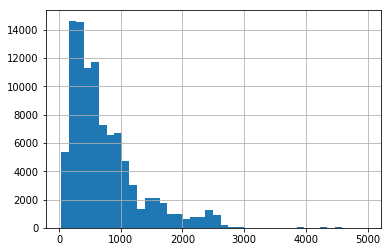

In [11]:
train_df.Distance.hist(bins=40)

In [12]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take logistic regression and two features that are easiest to take: DepTime and Distance. This will correspond to **"simple logit baseline"** on Public LB.

# Simple baseline

In [13]:
X_train = train_df[['Distance', 'DepTime']].values 
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [14]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [51]:
# logit_pipe.fit(X_train_part, y_train_part)
# logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

# roc_auc_score(y_valid, logit_valid_pred)

In [16]:
# logit_pipe.fit(X_train, y_train)
# logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

# fname = gen_subm_name('logit_2feat')
# print(fname)
# pd.Series(logit_test_pred, 
#           name='dep_delayed_15min').to_csv(fname, 
#                                            index_label='id', header=True)

subm_a3-3_20190329T125718_logit_2feat.csv


# Try other estimators

In [50]:
# ests = [('LogitPipe', logit_pipe),
# #         ("LinearSVC(C=10.0)", LinearSVC(C=10.0)), 
#         ('LR', LogisticRegression(C=1, random_state=17, solver='liblinear')),
#         ("LGBM", LGBMClassifier(random_state=17)), 
#         ("LGBM_100est", LGBMClassifier(random_state=17, n_estimators=100)),
#         ("XGBC_100est", XGBClassifier(random_state=17, n_estimators=100)),
#         ("rf_100est", RandomForestClassifier(random_state=17, n_estimators=100)),
#         ("cat_100est", CatBoostClassifier(random_state=17, n_estimators=100, verbose=0))]
# scores = []
# for name, est in ests:
#     %time est.fit(X_train_part, y_train_part)
#     est_pred = est.predict_proba(X_valid)[:, 1]
#     score = roc_auc_score(y_valid, est_pred)
#     scores.append(score)
#     print(name, score)


In [18]:
names = [x[0] for x in ests]
print(names)
print(scores)

['LogitPipe', 'LR', 'LGBM', 'LGBM_100est', 'XGBC_100est', 'rf_100est', 'cat_100est']
[0.6795691465352607, 0.6789733731013721, 0.7013297726588146, 0.7013297726588146, 0.6974401153652741, 0.6761078909042308, 0.6988959418502149]


<BarContainer object of 7 artists>

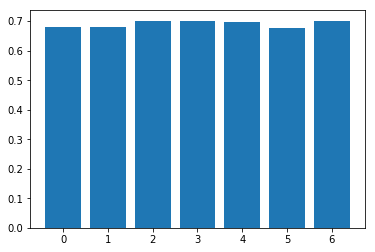

In [19]:
plt.bar(range(len(names)), scores)

# Process categorical feature

In [20]:
train_df = pd.read_csv('data/flight_delays_train.csv')
test_df = pd.read_csv('data/flight_delays_test.csv')

In [21]:
train_df['DepTime'] = train_df['DepTime'].apply(lambda x: '{0:0>4}'.format(x))
test_df['DepTime'] = test_df['DepTime'].apply(lambda x: '{0:0>4}'.format(x))

In [22]:
train_df[train_df['DepTime'] >= '2400']

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
3558,c-7,c-9,c-6,2400,B6,OAK,IAD,2408,Y
6423,c-9,c-7,c-3,2400,B6,SEA,JFK,2421,N
8189,c-6,c-14,c-2,2435,EV,CVG,AVL,275,Y
11652,c-12,c-9,c-6,2400,US,LAS,OAK,407,N
16603,c-3,c-27,c-7,2400,HP,LAS,ATL,1747,Y
20766,c-5,c-31,c-2,2534,EV,ATL,HSV,151,Y
24350,c-12,c-27,c-2,2400,DL,LAX,CVG,1900,N
27391,c-3,c-23,c-4,2505,EV,ATL,AGS,143,Y
44332,c-7,c-15,c-5,2440,EV,ATL,SHV,552,Y
45796,c-8,c-18,c-4,2447,EV,ATL,JAN,341,Y


In [23]:
test_df['DepTime'] = test_df['DepTime'].apply(lambda x: '0000' if x == '2400' else x)
train_df['DepTime'] = train_df['DepTime'].apply(lambda x: '{0:0>4}'.format(int(x)-2400) if x >= '2400' else x)

In [24]:
train_df.loc[99072]

Month                 c-4
DayofMonth           c-30
DayOfWeek             c-6
DepTime              0015
UniqueCarrier          EV
Origin                CAE
Dest                  ATL
Distance              191
dep_delayed_15min       Y
Name: 99072, dtype: object

In [25]:
train_df['DepTimeHM'] = pd.to_datetime(train_df['DepTime'], format='%H%M', errors='coerce')
test_df['DepTimeHM'] = pd.to_datetime(test_df['DepTime'], format='%H%M', errors='raise')

In [26]:
test_df[test_df.isnull().any(axis=1)]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,DepTimeHM


In [27]:
train_df[train_df.isnull().any(axis=1)]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTimeHM


In [28]:
print(train_df.shape)
print(test_df.shape)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
print(train_df.shape)
print(test_df.shape)

(100000, 10)
(100000, 9)
(100000, 10)
(100000, 9)


In [29]:
train_df['Hour'] = train_df['DepTimeHM'].apply(lambda ts: ts.hour).astype('int')
test_df['Hour'] = test_df['DepTimeHM'].apply(lambda ts: ts.hour).astype('int')


In [30]:
train_df['M'] = train_df['Hour'].apply(lambda x: 1 if (x >= 6 and x <= 11) else 0).astype('int')
train_df['D'] = train_df['Hour'].apply(lambda x: 1 if (x >= 12 and x <= 18) else 0).astype('int')
train_df['E'] = train_df['Hour'].apply(lambda x: 1 if (x >= 19 and x <= 23) else 0).astype('int')
train_df['N'] = train_df['Hour'].apply(lambda x: 1 if (x >= 0 and x <= 5) else 0).astype('int')

test_df['M'] = test_df['Hour'].apply(lambda x: 1 if (x >= 6 and x <= 11) else 0).astype('int')
test_df['D'] = test_df['Hour'].apply(lambda x: 1 if (x >= 12 and x <= 18) else 0).astype('int')
test_df['E'] = test_df['Hour'].apply(lambda x: 1 if (x >= 19 and x <= 23) else 0).astype('int')
test_df['N'] = test_df['Hour'].apply(lambda x: 1 if (x >= 0 and x <= 5) else 0).astype('int')


In [31]:
train_df['MonthD'] = train_df['Month'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
train_df['DayOfMD'] = train_df['DayofMonth'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
train_df['DayOfWD'] = train_df['DayOfWeek'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')

train_df['Holiday'] = train_df['DayOfWD'].apply(lambda x: 1 if (x >= 6) else 0).astype('int')


test_df['MonthD'] = test_df['Month'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
test_df['DayOfMD'] = test_df['DayofMonth'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
test_df['DayOfWD'] = test_df['DayOfWeek'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')

test_df['Holiday'] = test_df['DayOfWD'].apply(lambda x: 1 if (x >= 6) else 0).astype('int')



In [32]:
train_df['DistLog'] = np.log(train_df['Distance'])
test_df['DistLog'] = np.log(test_df['Distance'])

In [33]:
train_df["UnqCar"] = train_df["UniqueCarrier"].astype('category')
test_df["UnqCar"] = test_df["UniqueCarrier"].astype('category')

train_df["Org"] = train_df["Origin"].astype('category')
test_df["Org"] = test_df["Origin"].astype('category')

train_df["Dst"] = train_df["Dest"].astype('category')
test_df["Dst"] = test_df["Dest"].astype('category')

In [34]:
train_df["UnqCarC"] = train_df["UnqCar"].cat.codes
test_df["UnqCarC"] = test_df["UnqCar"].cat.codes

train_df["OrgC"] = train_df["Org"].cat.codes
test_df["OrgC"] = test_df["Org"].cat.codes

train_df["DstC"] = train_df["Dst"].cat.codes
test_df["DstC"] = test_df["Dst"].cat.codes

In [35]:
train_df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Month,100000,12,c-8,8830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayofMonth,100000,31,c-1,3399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,100000,7,c-4,14736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTime,100000,1285,0700,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UniqueCarrier,100000,22,WN,15082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Origin,100000,289,ATL,5834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,100000,289,ATL,5795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,100000,NaN,NaN,NaN,NaN,NaN,729.397,574.617,30,317,575,957,4962
dep_delayed_15min,100000,2,N,80956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DepTimeHM,100000,1285,1900-01-01 07:00:00,359,1900-01-01 00:00:00,1900-01-01 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 26 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null object
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
DepTimeHM            100000 non-null datetime64[ns]
Hour                 100000 non-null int64
M                    100000 non-null int64
D                    100000 non-null int64
E                    100000 non-null int64
N                    100000 non-null int64
MonthD               100000 non-null int64
DayOfMD              100000 non-null int64
DayOfWD              100000 non-null int64
Holiday              100000 non-null int64
DistLog              100000 non-null float64
UnqCar     

# One hot encoding

In [37]:
print(train_df.shape)
print(test_df.shape)

(100000, 26)
(100000, 25)


In [38]:
n_train = train_df.shape[0]
all_df = pd.concat([train_df, test_df])

In [39]:
print(all_df.shape)


(200000, 26)


In [40]:
all_df.tail()

,D,DayOfMD,DayOfWD,DayOfWeek,DayofMonth,DepTime,DepTimeHM,Dest,DistLog,Distance,...,Month,MonthD,N,Org,OrgC,Origin,UniqueCarrier,UnqCar,UnqCarC,dep_delayed_15min
99995,0,5,2,c-2,c-5,0852,1900-01-01 08:52:00,HOU,5.231109,187,...,c-6,6,0,CRP,70,CRP,WN,WN,17,NaN
99996,1,24,6,c-6,c-24,1446,1900-01-01 14:46:00,LAS,7.323171,1515,...,c-11,11,0,ORD,209,ORD,UA,UA,15,NaN
99997,1,30,2,c-2,c-30,1509,1900-01-01 15:09:00,SGF,6.082219,438,...,c-1,1,0,ORD,209,ORD,OO,OO,14,NaN
99998,0,5,5,c-5,c-5,0804,1900-01-01 08:04:00,ATL,6.634633,761,...,c-1,1,0,LGA,162,LGA,DL,DL,6,NaN
99999,0,29,1,c-1,c-29,0834,1900-01-01 08:34:00,MSP,5.693732,297,...,c-10,10,0,MKE,186,MKE,OO,OO,14,NaN


In [41]:
# train_df_dummies = pd.get_dummies(train_df[['Month', 'DayOfWeek', 'UniqueCarrier', 'Hour']])
# test_df_dummies = pd.get_dummies(test_df[['Month', 'DayOfWeek', 'UniqueCarrier', 'Hour']])

In [42]:
all_df_dummies = pd.get_dummies(all_df[['Month', 'DayOfWeek', 'UniqueCarrier', 'Hour']])


In [43]:
all_df_dummies.head()

,Hour,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,Month_c-6,...,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_TZ,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,10,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,18,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
#test_df_dummies.head()

In [45]:
train_df_dummies = all_df_dummies.iloc[:n_train]
test_df_dummies = all_df_dummies.iloc[n_train:]
print(train_df_dummies.shape)
print(test_df_dummies.shape)

(100000, 43)
(100000, 43)


In [46]:
# X_train_dummies = pd.concat((train_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
#                     'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']], train_df_dummies), axis=1).values 
# y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

# X_test_dummies = pd.concat((test_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
#                     'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']], test_df_dummies), axis=1).values 

In [47]:
X_train_dummies = pd.concat((train_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
                    'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']], train_df_dummies), axis=1) 
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

X_test_dummies = pd.concat((test_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
                    'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']], test_df_dummies), axis=1)

In [48]:
X_train_dum_part, X_valid_dum, y_train_dum_part, y_valid_dum = \
    train_test_split(X_train_dummies, y_train, 
                     test_size=0.3, random_state=17)

In [49]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
clf_pipe = Pipeline([('scaler', StandardScaler()),
                       ('lgbm', LGBMClassifier(random_state=5, n_estimators=500, learning_rate=0.1, reg_lambda=1.0))])

clf_pipe.fit(X_train_dum_part, y_train_dum_part)

In [ ]:
est_valid_pred = clf_pipe.predict_proba(X_valid_dum)[:, 1]
roc_auc_score(y_valid_dum, est_valid_pred)
# 0.7412265358265067

In [ ]:
%%time
clf = Pipeline([('scaler', StandardScaler()),
                       ('cat',CatBoostClassifier(random_state=5, n_estimators=500, learning_rate=0.1, reg_lambda=1.0))])
clf.fit(X_train_dum_part, y_train_dum_part)

In [ ]:
est_valid_pred = clf.predict_proba(X_valid_dum)[:, 1]
roc_auc_score(y_valid_dum, est_valid_pred)
# res: 0.7376394730003442

In [ ]:
# est_valid_pred = clf.predict_proba(X_valid_dum)[:, 1]
# roc_auc_score(y_valid_dum, est_valid_pred)
# res: 0.7377182019617423

In [ ]:
print(X_train_dummies.shape)
print(y_train.shape)
print(X_test_dummies.shape)

In [ ]:
clf_pipe.fit(X_train_dummies, y_train)
lgb_test_pred = clf_pipe.predict_proba(X_test_dummies)[:, 1]

fname = gen_subm_name('scaler-lgmb-500_dum_w_train_times_ge_2400_subtracted_24h_fine_tuned')
print(fname)
pd.Series(lgb_test_pred, 
          name='dep_delayed_15min').to_csv(fname, 
                                           index_label='id', header=True)

In [ ]:
raise(KeyboardInterrupt)

# Parameters tuning

In [ ]:
clf_pipe.get_params()

## NEW 0329: below is incorrect scoring!!!

In [ ]:
%%time 
est = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('lgbm', LGBMClassifier())]), 
                   param_grid={"lgbm__reg_lambda": [0.001, 0.01, 0.1, 1.0], 
                               "lgbm__n_estimators": [10, 100, 200, 500],
                               "lgbm__random_state": [5, 17, 30, 50],
                               "lgbm__learning_rate": [0.001, 0.01, 0.1]})
# plot_learning_curve(est, "lgbm(C=AUTO)", 
#                     X_train_dum_part, y_train_dum_part, ylim=(0.5, 1.0),
#                     train_sizes=np.linspace(0.2, 1.0, 5))
print("Chosen parameter: %s" % est.fit(X_train_dummies, y_train).best_params_)

In [ ]:
est.best_score_

In [ ]:
est.best_params_

In [ ]:
final_model = est.best_estimator_

In [ ]:
est_valid_pred = final_model.predict_proba(X_valid_dum)[:, 1]
print(roc_auc_score(y_valid_dum, est_valid_pred), "\n")

grid_search_report(est.cv_results_)

In [ ]:
%%time
subm_suffix = "lgb-gs-n192"
cv=5
train_and_predict(final_model, X_train_dum_part, y_train_dum_part, X_valid_dum, cv=cv, submission_suffix=subm_suffix)

# NEW0329: Hyperopt

In [ ]:
X_train_dum_part.shape

In [ ]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [ ]:
cv = 5
random_state = 42

params = {'cat__depth':[2,3,4,5,6,7,8,9,10,12],  # Note: max depth is 16!
          'cat__iterations':[47, 100, 220, 470, 1000, 2200],
          'cat__learning_rate':[0.100, 0.150, 0.220, 0.330, 0.470], 
          'cat__l2_leaf_reg':[1,2,5,10,22,47,100],
          'cat__border_count':[5,10,22,47,100,220],
          'cat__class_weights':[[1.0, 1.0], [1.0, 2.20], [1.0, 4.22]]
#           'cat__ctr_border_count':[50,5,10,20,100,200]
         }

def score_cv(params, random_state=random_state, cv=cv, X=X_train_dum_part, y=y_train_dum_part):
    # the function gets a set of variable parameters in "param"
    params = {'iterations': int(params['iterations']), 
              'depth': int(params['depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = CatBoostClassifier(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return score

In [ ]:
%%time
# possible values of parameters
space={'iterations': hp.quniform('iterations', 10, 100, 1),
       'depth' : hp.quniform('depth', 2, 8, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

n_iter = 10
random_state = 42
best=fmin(fn=score_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperopt will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

In [ ]:
%%time
# computing the score on the test set
model = CatBoostClassifier(random_state=random_state, iterations=int(best['iterations']),
                      depth=int(best['depth']),learning_rate=best['learning_rate'], verbose=False)

model.fit(X_train_dum_part, y_train_dum_part)
val_score=roc_auc_score(y_valid_dum, model.predict_proba(X_valid_dum)[:,1])

print("Best cv score {:.5f}, val score {:.5f}, params {}".format(val_score, score_cv(best), best))

# hpsklearn

In [52]:
from hpsklearn import HyperoptEstimator, any_classifier

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [64]:
def anti_roc_auc_score(y_true, y_pred):
    return -roc_auc_score(y_true, y_pred)

from sklearn.metrics import f1_score
def anti_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred)

In [57]:
est = HyperoptEstimator(loss_fn=anti_roc_auc_score)
est.fit(X_train_dum_part.values, y_train_dum_part.values)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/home/ant/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/home/ant/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)



100%|██████████| 1/1 [00:00<00:00,  3.26it/s, best loss: -0.6367151749484821]


/home/ant/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [68]:
preds = est.predict(X_valid_dum)
preds

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [66]:
f1_score(y_valid_dum, preds)

0.3739368165249089

In [67]:
est = HyperoptEstimator(loss_fn=anti_f1_score)
est.fit(X_train_dum_part.values, y_train_dum_part.values)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

# Further

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lgbm', LGBMClassifier())])
param_grid={"lgbm__reg_lambda": [0.001, 0.01, 0.1, 1.0], 
                               "lgbm__n_estimators": [10, 100, 200, 500],
                               "lgbm__random_state": [5, 17, 30, 50],
                               "lgbm__learning_rate": [0.001, 0.01, 0.1]}
# cv_ = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv = 5

In [ ]:
gridsearcher = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=4, cv=cv, verbose=5)

In [ ]:
%%time
gridsearcher.fit(X_train_dum_part, y_train_dum_part)

In [ ]:
gridsearcher.best_score_, gridsearcher.best_params_

In [ ]:
final_model = gridsearcher.best_estimator_

In [ ]:
train_and_predict(final_model, X_train_dum_part, y_train_dum_part, X_valid_dum, cv=cv, submission_suffix='123')

In [ ]:
raise(KeyboardInterrupt)

# Estimator choosing - failed

In [ ]:
%%time
from sklearn.preprocessing import MaxAbsScaler
from pipehelper import PipelineHelper

pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('classifier', PipelineHelper([
#         ('svm', LinearSVC()),
        ('rf', RandomForestClassifier()),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],  # just for displaying
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
#         'svm__C': [0.1, 1.0],
        'rf__n_estimators': [10, 20],
    })
}
grid = GridSearchCV(pipe, params, scoring='roc_auc', verbose=1)
grid.fit(X_train_dum_part, y_train_dum_part)
print(grid.best_params_)
print(grid.best_score_)

# Randomized grid

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lgbm', LGBMClassifier())])
param_grid={"lgbm__reg_lambda": [0.001, 0.01, 0.1, 1.0], 
                               "lgbm__n_estimators": [10, 100, 200],
#                                "lgbm__random_state": [5, 17, 30, 50],
                               "lgbm__learning_rate": [0.001, 0.01, 0.1]}
# cv_ = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv = 5

In [ ]:
%%time
n_iter = 10
gridsearcher = RandomizedSearchCV(pipe, param_grid, n_iter=n_iter, scoring='roc_auc', n_jobs=4, cv=cv, verbose=5)
gridsearcher.fit(X_train_dum_part, y_train_dum_part)

In [ ]:
gridsearcher.best_score_, gridsearcher.best_params_

In [ ]:
grid_search_report(gridsearcher.cv_results_)

In [ ]:
final_model = gridsearcher.best_estimator_
train_and_predict(final_model, X_train_dum_part, y_train_dum_part, X_valid_dum, cv=cv, submission_suffix='123')

In [ ]:
est_valid_pred = final_model.predict_proba(X_valid_dum)[:, 1]
roc_auc_score(y_valid_dum, est_valid_pred)

# Catboost tuning

In [ ]:
params = {'cat__depth':[3,1,2,6,4,5,7,8,9,10],
          'cat__iterations':[250,100,500],
          'cat__learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'cat__l2_leaf_reg':[3,1,5,10,100],
          'cat__border_count':[32,5,10,20,50,100,200],
          'cat__class_weights':[None, [1.0, 4.23]]
#           'cat__ctr_border_count':[50,5,10,20,100,200]
         }

In [ ]:
y_train_dum_part.value_counts()

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('cat', CatBoostClassifier(random_state=42))])
param_grid = params
# cv_ = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv = 5

In [ ]:
%%time
n_iter = 3
gridsearcher = RandomizedSearchCV(pipe, param_grid, n_iter=n_iter, scoring='roc_auc', n_jobs=4, cv=cv, verbose=5, random_state=42)
gridsearcher.fit(X_train_dum_part, y_train_dum_part)

In [ ]:
gridsearcher.best_score_, gridsearcher.best_params_
# (0.73743266444867,
#  {'cat__border_count': 20,
#   'cat__ctr_border_count': 50,
#   'cat__depth': 3,
#   'cat__iterations': 1000,
#   'cat__l2_leaf_reg': 10,
#   'cat__learning_rate': 0.2})

In [ ]:
grid_search_report(gridsearcher.cv_results_)

In [ ]:
final_model = gridsearcher.best_estimator_

In [ ]:
train_and_predict(final_model, X_train_dum_part, y_train_dum_part, X_valid_dum, cv=cv, submission_suffix='123')

In [ ]:
est_valid_pred = final_model.predict_proba(X_valid_dum)[:, 1]
roc_auc_score(y_valid_dum, est_valid_pred)
# 0.7339958772727908

# New 1

In [ ]:
ests = [('LogitPipe', logit_pipe),
#         ("LinearSVC(C=10.0)", LinearSVC(C=10.0)), 
        ('LR', LogisticRegression(C=1, random_state=17, solver='liblinear')),
        ("LGBM", LGBMClassifier(random_state=17)), 
        ("LGBM_100est", LGBMClassifier(random_state=17, n_estimators=100)),
        ("XGBC_100est", XGBClassifier(random_state=17, n_estimators=100)),
        ("rf_100est", RandomForestClassifier(random_state=17, n_estimators=100)),
        ("cat_100est", CatBoostClassifier(random_state=17, n_estimators=100, verbose=0))]
scores = []
for name, est in ests:
    %time est.fit(X_train_part, y_train_part)
    est_pred = est.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, est_pred)
    scores.append(score)
    print(name, score)

In [ ]:
%%time

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
ests = [("LinearSVC(C=10.0)", LinearSVC(C=10.0)), 
        ("LGBM", LGBMClassifier(random_state=17)), 
        ("LGBM_100est", LGBMClassifier(random_state=17, n_estimators=100)),
        ("XGBC_100est", XGBClassifier(random_state=17, n_estimators=100)),
        ("rf_100est", RandomForestClassifier(random_state=17, n_estimators=100)),
        ("cat_100est", catboost.CatBoostClassifier(random_state=17, n_estimators=100, verbose=0))]
for name, est in ests:
    print(name)
    %time plot_learning_curve(est, name, X_train_dum_part, y_train_dum_part, ylim=(0.0, 1.01), train_sizes=np.linspace(.1, .2, 5))
    plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

ests = [("LinearSVC(C=10.0)", LinearSVC(C=10.0)), 
        ("LGBM", LGBMClassifier(random_state=17)), 
        ("LGBM_100est", LGBMClassifier(random_state=17, n_estimators=100)),
        ("XGBC_100est", XGBClassifier(random_state=17, n_estimators=100)),
        ("rf_100est", RandomForestClassifier(random_state=17, n_estimators=100)),
        ("cat_100est", catboost.CatBoostClassifier(random_state=17, n_estimators=100, verbose=0))]

# SelectKBest(f_classif, k=2) will select the k=2 best features according to their Anova F-value
for k in range(X_train_dum_part.shape[1], 1, -1):
    print(k)
    for name, est in ests:
        print(name)
        plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=k)), # select two features
                               (name,  est)]),
                    "SelectKBest(f_classif, k={}) + {}".format(k, name),
                    X_train_dum_part, y_train_dum_part, ylim=(0.6, 0.8),
                    train_sizes=np.linspace(.1, 1.0, 5))
        plt.show()

In [ ]:
# <!-- collapse=True -->

# Modified from http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [ ]:
X_train = train_df[['Distance', 'DepTime']].values 
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [ ]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [ ]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

In [ ]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_2feat.csv', 
                                           index_label='id', header=True)

#### Добавление class_weight='balanced'

In [ ]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear', class_weight='balanced'))])

In [ ]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

Now you have to beat **"A3 baseline (8 credits)"** on Public LB. It's not challenging at all. Go for LightGBM, maybe some other models (or ensembling) as well. Include categorical features, do some simple feature engineering as well. Good luck!

# NEW 1

In [ ]:
import xgboost

In [ ]:
est_pipe = Pipeline([('scaler', StandardScaler()),
                       ('est', xgboost.XGBClassifier(n_estimators=100, random_state=17))])

In [ ]:
est_pipe.fit(X_train_part, y_train_part)
est_valid_pred = est_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, est_valid_pred)

In [ ]:
est_pipe.fit(X_train, y_train)
est_test_pred = est_pipe.predict_proba(X_test)[:, 1]

pd.Series(est_test_pred, 
          name='dep_delayed_15min').to_csv('est_2feat_2-1.csv', 
                                           index_label='id', header=True)

# NEW 2

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_pipe = Pipeline([('scaler', StandardScaler()),
                       ('lgb',lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=100))])

In [ ]:
lgb_pipe.fit(X_train_part, y_train_part)
# predict
# lgb_valid_pred = lgb_pipe.predict_proba(X_valid)[:, 1]
lgb_valid_pred = lgb_pipe.predict(X_valid)
roc_auc_score(y_valid, lgb_valid_pred)

In [ ]:
lgb_pipe.fit(X_train, y_train)
lgb_test_pred = lgb_pipe.predict(X_test)


pd.Series(lgb_test_pred, 
          name='dep_delayed_15min').to_csv('est_2feat_3-2.csv', 
                                           index_label='id', header=True)

# NEW 3

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, roc_auc_score

In [ ]:
X_train1 = train_df[['DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Distance', 'DepTime']].values
X_test1 = test_df[['DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Distance', 'DepTime']].values
X_train_part1, X_valid1, y_train_part1, y_valid1 = \
    train_test_split(X_train1, y_train, 
                     test_size=0.3, random_state=17)

In [ ]:
lgb_pipe = Pipeline([('scaler', StandardScaler()),
                       ('lgb',lgb.LGBMClassifier(learning_rate = 0.125, 
                        n_estimators = 100))])

In [ ]:
lgb_pipe.fit(X_train_part1, y_train_part1)
# predict
# lgb_valid_pred = lgb_pipe.predict_proba(X_valid)[:, 1]
lgb_valid_pred1 = lgb_pipe.predict(X_valid1)
roc_auc_score(y_valid1, lgb_valid_pred1)

In [ ]:
param_grid = {
    'n_estimators': [x for x in range(20, 100, 10)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2, 0.5]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train_part, y_train_part,
        eval_set = [(X_valid, y_valid)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

In [ ]:
gridsearch.best_params_

In [ ]:
lgb_pipe = Pipeline([('scaler', StandardScaler()),
                       ('lgb',lgb.LGBMRegressor(learning_rate = 0.1, 
                        n_estimators = 500))])

In [ ]:
lgb_pipe.fit(X_train_part, y_train_part)
# predict
# lgb_valid_pred = lgb_pipe.predict_proba(X_valid)[:, 1]
lgb_valid_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
roc_auc_score(y_valid, lgb_valid_pred)

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [ ]:
lgb_valid_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
roc_auc_score(y_valid, lgb_valid_pred)

# NEW 4

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
train_df = pd.read_csv('../../../data/flight_delays_train.csv')
test_df = pd.read_csv('../../../data/flight_delays_test.csv')

In [ ]:
train_df['dep_delayed_15min'].value_counts()

In [ ]:
train_df['DepTime'] = train_df['DepTime'].apply(lambda x: '{0:0>4}'.format(x))
test_df['DepTime'] = test_df['DepTime'].apply(lambda x: '{0:0>4}'.format(x))


In [ ]:
train_df['DepTimeHM'] = pd.to_datetime(train_df['DepTime'], format='%H%M', errors='coerce')
test_df['DepTimeHM'] = pd.to_datetime(test_df['DepTime'], format='%H%M', errors='coerce')

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
# train_df['DepTimeHM'].dropna(inplace=True)
# test_df['DepTimeHM'].dropna(inplace=True)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
train_df['Hour'] = train_df['DepTimeHM'].apply(lambda ts: ts.hour).astype('int')
test_df['Hour'] = test_df['DepTimeHM'].apply(lambda ts: ts.hour).astype('int')


In [ ]:
train_df['M'] = train_df['Hour'].apply(lambda x: 1 if (x >= 6 and x <= 11) else 0).astype('int')
train_df['D'] = train_df['Hour'].apply(lambda x: 1 if (x >= 12 and x <= 18) else 0).astype('int')
train_df['E'] = train_df['Hour'].apply(lambda x: 1 if (x >= 19 and x <= 23) else 0).astype('int')
train_df['N'] = train_df['Hour'].apply(lambda x: 1 if (x >= 0 and x <= 5) else 0).astype('int')

test_df['M'] = test_df['Hour'].apply(lambda x: 1 if (x >= 6 and x <= 11) else 0).astype('int')
test_df['D'] = test_df['Hour'].apply(lambda x: 1 if (x >= 12 and x <= 18) else 0).astype('int')
test_df['E'] = test_df['Hour'].apply(lambda x: 1 if (x >= 19 and x <= 23) else 0).astype('int')
test_df['N'] = test_df['Hour'].apply(lambda x: 1 if (x >= 0 and x <= 5) else 0).astype('int')


In [ ]:
train_df['MonthD'] = train_df['Month'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
train_df['DayOfMD'] = train_df['DayofMonth'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
train_df['DayOfWD'] = train_df['DayOfWeek'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')

train_df['Holiday'] = train_df['DayOfWD'].apply(lambda x: 1 if (x >= 6) else 0).astype('int')


test_df['MonthD'] = test_df['Month'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
test_df['DayOfMD'] = test_df['DayofMonth'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')
test_df['DayOfWD'] = test_df['DayOfWeek'].replace(to_replace=r'^c\-', value='', regex=True).astype('int')

test_df['Holiday'] = test_df['DayOfWD'].apply(lambda x: 1 if (x >= 6) else 0).astype('int')



In [ ]:
train_df['DistLog'] = np.log(train_df['Distance'])
test_df['DistLog'] = np.log(test_df['Distance'])

In [ ]:
train_df["UnqCar"] = train_df["UniqueCarrier"].astype('category')
test_df["UnqCar"] = test_df["UniqueCarrier"].astype('category')

train_df["Org"] = train_df["Origin"].astype('category')
test_df["Org"] = test_df["Origin"].astype('category')

train_df["Dst"] = train_df["Dest"].astype('category')
test_df["Dst"] = test_df["Dest"].astype('category')

In [ ]:
train_df["UnqCarC"] = train_df["UnqCar"].cat.codes
test_df["UnqCarC"] = test_df["UnqCar"].cat.codes

train_df["OrgC"] = train_df["Org"].cat.codes
test_df["OrgC"] = test_df["Org"].cat.codes

train_df["DstC"] = train_df["Dst"].cat.codes
test_df["DstC"] = test_df["Dst"].cat.codes

In [ ]:
# train_df['Hour'].dropna(inplace=True)
# test_df['Hour'].dropna(inplace=True)

In [ ]:
train_df.describe(include='all').T

In [ ]:
train_df.info()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
%%time
plot_corr(train_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
                    'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']])

In [ ]:
X_train = train_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
                    'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']].values 
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['DistLog', 'MonthD', 'DayOfMD', 'DayOfWD', 
                    'M', 'D', 'E', 'N', 'Holiday', 'UnqCarC', 'OrgC', 'DstC', 'DepTime']].values

In [ ]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [ ]:
X_train[0]

In [ ]:
clf_pipe = Pipeline([('scaler', StandardScaler()),
                       ('lgbm', LGBMClassifier(random_state=17))])

clf_pipe.fit(X_train_part, y_train_part)

In [ ]:
est_valid_pred = clf_pipe.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, est_valid_pred)

In [ ]:
clf_pipe.fit(X_train, y_train)
lgb_test_pred = clf_pipe.predict_proba(X_test)[:, 1]

pd.Series(lgb_test_pred, 
          name='dep_delayed_15min').to_csv('est_2feat_4-5_lgb.csv', 
                                           index_label='id', header=True)

### CatBOOST

In [ ]:
import catboost

In [ ]:
est = catboost.CatBoostClassifier(n_estimators=100)
est.fit(X_train_part, y_train_part)

In [ ]:
est_valid_pred = est.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, est_valid_pred)

In [ ]:
%%time
est = catboost.CatBoostClassifier(n_estimators=200)
est.fit(X_train_part, y_train_part)

In [ ]:
est_valid_pred = est.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, est_valid_pred)

In [ ]:
est.fit(X_train, y_train)
cat_test_pred = est.predict_proba(X_test)[:, 1]

pd.Series(cat_test_pred, 
          name='dep_delayed_15min').to_csv('est_2feat_4-4_catboost.csv', 
                                           index_label='id', header=True)

In [ ]:
logit = LogisticRegression(C=1, solver='liblinear',
                           random_state=17)
logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])

In [ ]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

In [ ]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('est_2feat_4-2.csv', 
                                           index_label='id', header=True)

# New 6.1 learning curves

In [ ]:
%%time

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
ests = [("LinearSVC(C=10.0)", LinearSVC(C=10.0)), 
        ("LGBM", LGBMClassifier(random_state=17)), 
        ("LGBM_100est", LGBMClassifier(random_state=17, n_estimators=100)),
        ("XGBC_100est", XGBClassifier(random_state=17, n_estimators=100)),
        ("rf_100est", RandomForestClassifier(random_state=17, n_estimators=100)),
        ("cat_100est", catboost.CatBoostClassifier(random_state=17, n_estimators=100, verbose=0))]
for name, est in ests:
    print(name)
    %time plot_learning_curve(est, name, X_train_part, y_train_part, ylim=(0.0, 1.01), train_sizes=np.linspace(.1, .2, 5))
    plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
# SelectKBest(f_classif, k=2) will select the k=2 best features according to their Anova F-value

for k in range(X_train_part.shape[1], 1, -1):
    print(k)
    plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=k)), # select two features
                               ("LGBMClassifier",  LGBMClassifier(random_state=17, n_estimators=100))]),
                    "SelectKBest(f_classif, k={}) + LGBMClassifier".format(k),
                    X_train_part, y_train_part, ylim=(0.6, 0.8),
                    train_sizes=np.linspace(.1, 1.0, 5))
    plt.show()

# NEW 4.1 logit

In [ ]:
logit = LogisticRegression(C=1, solver='liblinear',
                           random_state=17, class_weight='balanced')
logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])

In [ ]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

# NEW 5

In [ ]:
train_df[train_df['dep_delayed_15min'] == 'Y'].UniqueCarrier.value_counts()


In [ ]:
train_df[train_df['dep_delayed_15min'] == 'N'].UniqueCarrier.value_counts()

In [ ]:
crosstab_df = pd.crosstab(train_df.UniqueCarrier, train_df.dep_delayed_15min)
crosstab_df['Ratio'] = crosstab_df.Y / crosstab_df.N

In [ ]:
crosstab_df.sort_values(by='Ratio')

In [ ]:
# NEW 6